In [1]:
# import necessary packages
import time
import datetime

import math
import numpy as np
import pandas as pd
import pickle

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import annoy
from annoy import AnnoyIndex
import random

import antares_client
from alerce.core import Alerce
alerce = Alerce()

import requests
from requests.auth import HTTPBasicAuth

import matplotlib
from matplotlib.transforms import Bbox
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import astropy.table as at
from astropy.table import MaskedColumn
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
import astropy.units as u
from astropy.visualization import PercentileInterval, AsinhStretch
from astroquery.mast import Catalogs
from astroquery.sdss import SDSS
from astroquery.simbad import Simbad

import light_curve as lc
from itertools import chain

from PIL import Image
import os
import sys
import shutil
import glob
import json

import astro_ghost
from astro_ghost.ghostHelperFunctions import getTransientHosts, getGHOST
import tempfile

# Throw RA/DEC into ghost with just DLR method, gentle starcut
# Sets environ var to find ghost.csv
os.environ['GHOST_PATH'] = './host_info'
# Then don't use getGHOST(real=True, verbose=verbose)
getGHOST(real=True,verbose=False)

import warnings
warnings.filterwarnings("ignore")

plt.style.use('fig_publication.mplstyle')

GHOST database already exists in the install path!


In [2]:
# GHOST getTransientHosts function with timeout
from timeout_decorator import timeout, TimeoutError
@timeout(120)  # Set a timeout of 60 seconds to query GHOST throughput APIs for host galaxy data
def getTransientHosts_with_timeout(**args):
    #time.sleep(6) #- to test
    return astro_ghost.ghostHelperFunctions.getTransientHosts(**args)


# Functions to extract light-curve features
def replace_magn_with_flux(s):
    if 'magnitude' in s:
        return s.replace('magnitudes', 'fluxes').replace('magnitude', 'flux')
    return f'{s} for flux light curve'

def create_base_features_class(
        magn_extractor,
        flux_extractor,
        bands=('R', 'g',),
    ):
    feature_names = ([f'{name}_magn' for name in magn_extractor.names]
                     + [f'{name}_flux' for name in flux_extractor.names])
    
    property_names = {band: [f'feature_{name}_{band}'.lower()
                             for name in feature_names]
                      for band in bands}
    
    features_count = len(feature_names)
    
    return feature_names, property_names, features_count


MAGN_EXTRACTOR = lc.Extractor(
    lc.Amplitude(),
    lc.AndersonDarlingNormal(),
    lc.BeyondNStd(1.0),
    lc.BeyondNStd(2.0),
    lc.Cusum(),
    lc.EtaE(),
    lc.InterPercentileRange(0.02),
    lc.InterPercentileRange(0.1),
    lc.InterPercentileRange(0.25),
    lc.Kurtosis(),
    lc.LinearFit(),
    lc.LinearTrend(),
    lc.MagnitudePercentageRatio(0.4, 0.05),
    lc.MagnitudePercentageRatio(0.2, 0.05),
    lc.MaximumSlope(),
    lc.Mean(),
    lc.MedianAbsoluteDeviation(),
    lc.PercentAmplitude(),
    lc.PercentDifferenceMagnitudePercentile(0.05),
    lc.PercentDifferenceMagnitudePercentile(0.1),
    lc.MedianBufferRangePercentage(0.1),
    lc.MedianBufferRangePercentage(0.2),
    lc.Periodogram(
        peaks=5,
        resolution=10.0,
        max_freq_factor=2.0,
        nyquist='average',
        fast=True,
        features=(
            lc.Amplitude(),
            lc.BeyondNStd(2.0),
            lc.BeyondNStd(3.0),
            lc.StandardDeviation(),
        ),
    ),
    lc.ReducedChi2(),
    lc.Skew(),
    lc.StandardDeviation(),
    lc.StetsonK(),
    lc.WeightedMean(),
)

FLUX_EXTRACTOR = lc.Extractor(
    lc.AndersonDarlingNormal(),
    lc.Cusum(),
    lc.EtaE(),
    lc.ExcessVariance(),
    lc.Kurtosis(),
    lc.MeanVariance(),
    lc.ReducedChi2(),
    lc.Skew(),
    lc.StetsonK(),
)

def remove_simultaneous_alerts(table):
    """Remove alert duplicates"""
    dt = np.diff(table['ant_mjd'], append=np.inf)
    return table[dt != 0]
    
def get_detections(photometry, band):
    """Extract clean light curve in given band from locus photometry"""
    band_lc = photometry[(photometry['ant_passband'] == band) & (~photometry['ant_mag'].isna())]
    idx = ~MaskedColumn(band_lc['ant_mag']).mask
    detections = remove_simultaneous_alerts(band_lc[idx])
    return detections

In [3]:
# From 106 available features from Kostya's lc_feature_extractor, use the 82 from SNAD Miner paper 
# R and g bands
feature_names_r_g = ['feature_amplitude_magn_r', 
                 'feature_anderson_darling_normal_magn_r',
                 'feature_beyond_1_std_magn_r', 
                 'feature_beyond_2_std_magn_r',
                 'feature_cusum_magn_r', 
                 #'feature_eta_e_magn_r',
                 'feature_inter_percentile_range_2_magn_r',
                 'feature_inter_percentile_range_10_magn_r',
                 'feature_inter_percentile_range_25_magn_r', 
                 'feature_kurtosis_magn_r',
                 'feature_linear_fit_slope_magn_r',
                 'feature_linear_fit_slope_sigma_magn_r',
                 #'feature_linear_fit_reduced_chi2_magn_r', 
                 #'feature_linear_trend_magn_r', # cadence removal
                 #'feature_linear_trend_sigma_magn_r',  # cadence removal
                 'feature_magnitude_percentage_ratio_40_5_magn_r',
                 'feature_magnitude_percentage_ratio_20_5_magn_r',
                 #'feature_maximum_slope_magn_r',
                 'feature_mean_magn_r',
                 'feature_median_absolute_deviation_magn_r',
                 'feature_percent_amplitude_magn_r',
                 'feature_median_buffer_range_percentage_10_magn_r',
                 'feature_median_buffer_range_percentage_20_magn_r',
                 'feature_percent_difference_magnitude_percentile_5_magn_r',
                 'feature_percent_difference_magnitude_percentile_10_magn_r',
                 #'feature_period_0_magn_r',  # should be negated
                 #'feature_period_s_to_n_0_magn_r', # cadence removal
                 #'feature_period_1_magn_r', 
                 #'feature_period_s_to_n_1_magn_r', # cadence removal
                 #'feature_period_2_magn_r', 
                 #'feature_period_s_to_n_2_magn_r', # cadence removal
                 #'feature_period_3_magn_r', 
                 #'feature_period_s_to_n_3_magn_r', # cadence removal
                 #'feature_period_4_magn_r', 
                 #'feature_period_s_to_n_4_magn_r', # cadence removal
                 #'feature_periodogram_amplitude_magn_r',
                 #'feature_periodogram_beyond_2_std_magn_r',  # cadence removal
                 #'feature_periodogram_beyond_3_std_magn_r',  # cadence removal
                 #'feature_periodogram_standard_deviation_magn_r',   # cadence removal
                 #'feature_chi2_magn_r',
                 'feature_skew_magn_r', 
                 'feature_standard_deviation_magn_r',
                 'feature_stetson_k_magn_r',
                 'feature_weighted_mean_magn_r',
                 'feature_anderson_darling_normal_flux_r', 
                 'feature_cusum_flux_r',
                 #'feature_eta_e_flux_r', 
                 'feature_excess_variance_flux_r',
                 'feature_kurtosis_flux_r', 
                 'feature_mean_variance_flux_r',
                 #'feature_chi2_flux_r', 
                 'feature_skew_flux_r',
                 'feature_stetson_k_flux_r',

                 'feature_amplitude_magn_g', 
                 'feature_anderson_darling_normal_magn_g',
                 'feature_beyond_1_std_magn_g', 
                 'feature_beyond_2_std_magn_g',
                 'feature_cusum_magn_g', 
                 #'feature_eta_e_magn_g',
                 'feature_inter_percentile_range_2_magn_g',
                 'feature_inter_percentile_range_10_magn_g',
                 'feature_inter_percentile_range_25_magn_g', 
                 'feature_kurtosis_magn_g',
                 'feature_linear_fit_slope_magn_g',
                 'feature_linear_fit_slope_sigma_magn_g',
                 #'feature_linear_fit_reduced_chi2_magn_g', 
                 #'feature_linear_trend_magn_g', # cadence removal
                 #'feature_linear_trend_sigma_magn_g',  # cadence removal
                 'feature_magnitude_percentage_ratio_40_5_magn_g',
                 'feature_magnitude_percentage_ratio_20_5_magn_g',
                 #'feature_maximum_slope_magn_g', 
                 'feature_mean_magn_g',
                 'feature_median_absolute_deviation_magn_g',
                 'feature_median_buffer_range_percentage_10_magn_g',
                 'feature_median_buffer_range_percentage_20_magn_g',
                 'feature_percent_amplitude_magn_g',
                 'feature_percent_difference_magnitude_percentile_5_magn_g',
                 'feature_percent_difference_magnitude_percentile_10_magn_g',
                 #'feature_period_0_magn_g',  # should be negated
                 #'feature_period_s_to_n_0_magn_g', # cadence removal
                 #'feature_period_1_magn_g', 
                 #'feature_period_s_to_n_1_magn_g', # cadence removal
                 #'feature_period_2_magn_g', 
                 #'feature_period_s_to_n_2_magn_g', # cadence removal
                 #'feature_period_3_magn_g', 
                 #'feature_period_s_to_n_3_magn_g', # cadence removal
                 #'feature_period_4_magn_g', 
                 #'feature_period_s_to_n_4_magn_g', # cadence removal
                 #'feature_periodogram_amplitude_magn_g',
                 #'feature_periodogram_beyond_2_std_magn_g',  # cadence removal
                 #'feature_periodogram_beyond_3_std_magn_g', # cadence removal
                 #'feature_periodogram_standard_deviation_magn_g',  # cadence removal
                 #'feature_chi2_magn_g',
                 'feature_skew_magn_g', 
                 'feature_standard_deviation_magn_g',
                 'feature_stetson_k_magn_g', 
                 'feature_weighted_mean_magn_g',
                 'feature_anderson_darling_normal_flux_g', 
                 'feature_cusum_flux_g',
                 #'feature_eta_e_flux_g', 
                 'feature_excess_variance_flux_g',
                 'feature_kurtosis_flux_g', 
                 'feature_mean_variance_flux_g',
                 #'feature_chi2_flux_g', 
                 'feature_skew_flux_g',
                 'feature_stetson_k_flux_g']   

feature_names_hostgal = [
    #  'Unnamed: 0',
    #  'level_0',
    #  'index',
    #  'objName',
    #  'objAltName1',
    #  'objAltName2',
    #  'objAltName3',
    #  'objID',
    #  'uniquePspsOBid',
    #  'ippObjID',
    #  'surveyID',
    #  'htmID',
    #  'zoneID',
    #  'tessID',
    #  'projectionID',
    #  'skyCellID',
    #  'randomID',
    #  'batchID',
    #  'dvoRegionID',
    #  'processingVersion',
    #  'objInfoFlag',
    #  'qualityFlag',
    #  'raStack',
    #  'decStack',
    #  'raStackErr',
    #  'decStackErr',
    #  'raMean',
    #  'decMean',
    #  'raMeanErr',
    #  'decMeanErr',
    #  'epochMean',
    #  'posMeanChisq',
    #  'cx',
    #  'cy',
    #  'cz',
    #  'lambda',
    #  'beta',
    #  'l',
    #  'b',
    #  'nStackObjectRows',
    #  'nStackDetections',
    #  'nDetections',
    #  'ng',
    #  'nr',
    #  'ni',
    #  'nz',
    #  'ny',
    #  'uniquePspsSTid',
    #  'primaryDetection',
    #  'bestDetection',
    #  'gippDetectID',
    #  'gstackDetectID',
    #  'gstackImageID',
    #  'gra',
    #  'gdec',
    #  'graErr',
    #  'gdecErr',
    #  'gEpoch',
    #  'gPSFMag',
    #  'gPSFMagErr',
    #  'gApMag',
    #  'gApMagErr',
    #  'gKronMag',
    #  'gKronMagErr',
    #  'ginfoFlag',
    #  'ginfoFlag2',
    #  'ginfoFlag3',
    #  'gnFrames',
    #  'gxPos',
    #  'gyPos',
    #  'gxPosErr',
    #  'gyPosErr',
    #  'gpsfMajorFWHM',
    #  'gpsfMinorFWHM',
    #  'gpsfTheta',
    #  'gpsfCore',
    #  'gpsfLikelihood',
    #  'gpsfQf',
    #  'gpsfQfPerfect',
    #  'gpsfChiSq',
     'gmomentXX',
     'gmomentXY',
     'gmomentYY',
     'gmomentR1',
     'gmomentRH',
     'gPSFFlux',
    #  'gPSFFluxErr',
     'gApFlux',
    #  'gApFluxErr',
    #  'gApFillFac',
    #  'gApRadius',
     'gKronFlux',
    #  'gKronFluxErr',
     'gKronRad',
    #  'gexpTime',
     'gExtNSigma',
    #  'gsky',
    #  'gskyErr',
    #  'gzp',
    #  'gPlateScale',
    #  'rippDetectID',
    #  'rstackDetectID',
    #  'rstackImageID',
    #  'rra',
    #  'rdec',
    #  'rraErr',
    #  'rdecErr',
    #  'rEpoch',
    # 'rPSFMag',
    #  'rPSFMagErr',
    # 'rApMag',
    #  'rApMagErr',
    # 'rKronMag',
    #  'rKronMagErr',
    #  'rinfoFlag',
    #  'rinfoFlag2',
    #  'rinfoFlag3',
    #  'rnFrames',
    #  'rxPos',
    #  'ryPos',
    #  'rxPosErr',
    #  'ryPosErr',
    #  'rpsfMajorFWHM',
    #  'rpsfMinorFWHM',
    #  'rpsfTheta',
    #  'rpsfCore',
    #  'rpsfLikelihood',
    #  'rpsfQf',
    #  'rpsfQfPerfect',
    #  'rpsfChiSq',
     'rmomentXX',
     'rmomentXY',
     'rmomentYY',
     'rmomentR1',
     'rmomentRH',
    'rPSFFlux',
    #  'rPSFFluxErr',
    'rApFlux',
    #  'rApFluxErr',
    #  'rApFillFac',
    # 'rApRadius',
    'rKronFlux',
    #  'rKronFluxErr',
    'rKronRad',
    #  'rexpTime',
     'rExtNSigma',
    #  'rsky',
    #  'rskyErr',
    #  'rzp',
    #  'rPlateScale',
    #  'iippDetectID',
    #  'istackDetectID',
    #  'istackImageID',
    #  'ira',
    #  'idec',
    #  'iraErr',
    #  'idecErr',
    #  'iEpoch',
    #  'iPSFMag',
    #  'iPSFMagErr',
    #  'iApMag',
    #  'iApMagErr',
    #  'iKronMag',
    #  'iKronMagErr',
    #  'iinfoFlag',
    #  'iinfoFlag2',
    #  'iinfoFlag3',
    #  'inFrames',
    #  'ixPos',
    #  'iyPos',
    #  'ixPosErr',
    #  'iyPosErr',
    #  'ipsfMajorFWHM',
    #  'ipsfMinorFWHM',
    #  'ipsfTheta',
    #  'ipsfCore',
    #  'ipsfLikelihood',
    #  'ipsfQf',
    #  'ipsfQfPerfect',
    #  'ipsfChiSq',
      'imomentXX',
     'imomentXY',
     'imomentYY',
     'imomentR1',
     'imomentRH',
     'iPSFFlux',
    #  'iPSFFluxErr',
     'iApFlux',
    #  'iApFluxErr',
    #  'iApFillFac',
    #  'iApRadius',
     'iKronFlux',
    #  'iKronFluxErr',
     'iKronRad',
    #  'iexpTime',
      'iExtNSigma',
    #  'isky',
    #  'iskyErr',
    #  'izp',
    #  'iPlateScale',
    #  'zippDetectID',
    #  'zstackDetectID',
    #  'zstackImageID',
    #  'zra',
    #  'zdec',
    #  'zraErr',
    #  'zdecErr',
    #  'zEpoch',
    #  'zPSFMag',
    #  'zPSFMagErr',
    #  'zApMag',
    #  'zApMagErr',
    #  'zKronMag',
    #  'zKronMagErr',
    #  'zinfoFlag',
    #  'zinfoFlag2',
    #  'zinfoFlag3',
    #  'znFrames',
    #  'zxPos',
    #  'zyPos',
    #  'zxPosErr',
    #  'zyPosErr',
    #  'zpsfMajorFWHM',
    #  'zpsfMinorFWHM',
    #  'zpsfTheta',
    #  'zpsfCore',
    #  'zpsfLikelihood',
    #  'zpsfQf',
    #  'zpsfQfPerfect',
    #  'zpsfChiSq',
      'zmomentXX',
     'zmomentXY',
     'zmomentYY',
     'zmomentR1',
     'zmomentRH',
     'zPSFFlux',
    # #  'zPSFFluxErr',
     'zApFlux',
    # #  'zApFluxErr',
    # #  'zApFillFac',
    # #  'zApRadius',
     'zKronFlux',
    # #  'zKronFluxErr',
     'zKronRad',
    # #  'zexpTime',
      'zExtNSigma',
    #  'zsky',
    #  'zskyErr',
    #  'zzp',
    #  'zPlateScale',
    #  'yippDetectID',
    #  'ystackDetectID',
    #  'ystackImageID',
    #  'yra',
    #  'ydec',
    #  'yraErr',
    #  'ydecErr',
    #  'yEpoch',
    #  'yPSFMag',
    #  'yPSFMagErr',
    #  'yApMag',
    #  'yApMagErr',
    #  'yKronMag',
    #  'yKronMagErr',
    #  'yinfoFlag',
    #  'yinfoFlag2',
    #  'yinfoFlag3',
    #  'ynFrames',
    #  'yxPos',
    #  'yyPos',
    #  'yxPosErr',
    #  'yyPosErr',
    #  'ypsfMajorFWHM',
    #  'ypsfMinorFWHM',
    #  'ypsfTheta',
    #  'ypsfCore',
    #  'ypsfLikelihood',
    #  'ypsfQf',
    #  'ypsfQfPerfect',
    #  'ypsfChiSq',
      'ymomentXX',
      'ymomentXY',
      'ymomentYY',
      'ymomentR1',
      'ymomentRH',
      'yPSFFlux',
    # #   'yPSFFluxErr',
      'yApFlux',
    # #   'yApFluxErr',
    # #   'yApFillFac',
    # #  'yApRadius',
     'yKronFlux',
    # #  'yKronFluxErr',
     'yKronRad',
    # #  'yexpTime',
      'yExtNSigma',
    #  'ysky',
    #  'yskyErr',
    #  'yzp',
    #  'yPlateScale',
    #  'distance',
    #  'SkyMapper_StarClass',
    #  'gelong',
    #  'g_a',
    #  'g_b',
    #  'g_pa',
    #  'relong',
    #  'r_a',
    #  'r_b',
    #  'r_pa',
    #  'ielong',
    #  'i_a',
    #  'i_b',
    #  'i_pa',
    #  'zelong',
    #  'z_a',
    #  'z_b',
    #  'z_pa',
       'i-z', # try throwing in
    #    'g-r',
    #    'r-i',
    #    'g-i',
    #    'z-y',
    #   'g-rErr',
    #   'r-iErr',
    #   'i-zErr',
    #   'z-yErr',
     'gApMag_gKronMag',
     'rApMag_rKronMag',
     'iApMag_iKronMag',
     'zApMag_zKronMag',
     'yApMag_yKronMag',
     '7DCD', 
    #  'NED_name',
    #  'NED_type',
    #  'NED_vel',
    #  'NED_redshift',
    #  'NED_mag',
    #  'class',
       'dist/DLR',
    #   'dist',
    #  'TransientClass',
    #  'TransientRA',
    #  'TransientDEC'
       ]


lc_and_host_features = feature_names_r_g + feature_names_hostgal

In [23]:
# Hyperparameters for best AD model
n_estimators=100 
max_depth=35 
random_state=11
max_features=35 # {“sqrt”, “log2”, None}, int or float, default=”sqrt” - sqrt(120) ~ 10
class_weight={"Normal": 1, "Other": 1} #"balanced"

figure_path = f"/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/RFC/SMOTE_train_test_70-30_min14_kneighbors8/cls=binary_n_estimators={n_estimators}_max_depth={max_depth}_rs={random_state}_max_feats={max_features}_cw=balanced/figures"
model_path = f"/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/RFC/SMOTE_train_test_70-30_min14_kneighbors8/cls=binary_n_estimators={n_estimators}_max_depth={max_depth}_rs={random_state}_max_feats={max_features}_cw=balanced/model"
if not os.path.exists(figure_path):
    os.makedirs(figure_path)
    
if not os.path.exists(model_path):
    os.makedirs(model_path)
    
with open(f'{model_path}/cls=binary_n_estimators={n_estimators}_max_depth={max_depth}_rs={random_state}_max_feats={max_features}_cw=balanced.pkl', 'rb') as f:
    clf = pickle.load(f)


def plot_RFC_prob_vs_lc_ztfid(clf, anom_ztfid, anom_spec_cls, anom_spec_z, anom_thresh, lc_and_hosts_df, lc_and_hosts_df_120d, ref_info, savefig, figure_path):
    anom_thresh = anom_thresh
    anom_obj_df = lc_and_hosts_df_120d

    try:
        pred_prob_anom = 100 * clf.predict_proba(anom_obj_df)
        pred_prob_anom[:, 0] = [round(a, 1) for a in pred_prob_anom[:, 0]]
        pred_prob_anom[:, 1] = [round(b, 1) for b in pred_prob_anom[:, 1]]
        num_anom_epochs = len(np.where(pred_prob_anom[:, 1]>=anom_thresh)[0])
    except:
        print(f"{anom_ztfid} has some NaN host galaxy values from PS1 catalog. Skip!")
        return

    try: 
        anom_idx = lc_and_hosts_df.iloc[np.where(pred_prob_anom[:, 1]>=anom_thresh)[0][0]].obs_num
        anom_idx_is = True
        print("Anomalous during timeseries!")

    except: 
        print(f"Prediction doesn't exceed anom_threshold of {anom_thresh}% for {anom_ztfid}.")
        anom_idx_is = False

    max_anom_score = max(pred_prob_anom[:, 1])
    print("max_anom_score", round(max_anom_score, 1))
    print("num_anom_epochs", num_anom_epochs)
    
    ztf_id_ref = anom_ztfid 

    ref_info = ref_info

    df_ref = ref_info.timeseries.to_pandas()

    df_ref_g = df_ref[(df_ref.ant_passband == 'g') & (~df_ref.ant_mag.isna())]
    df_ref_r = df_ref[(df_ref.ant_passband == 'R') & (~df_ref.ant_mag.isna())]

    mjd_idx_at_min_mag_r_ref = df_ref_r[['ant_mag']].reset_index().idxmin().ant_mag
    mjd_idx_at_min_mag_g_ref = df_ref_g[['ant_mag']].reset_index().idxmin().ant_mag

    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(7,10))
    ax1.invert_yaxis()
    ax1.errorbar(x=df_ref_r.ant_mjd, y=df_ref_r.ant_mag, yerr=df_ref_r.ant_magerr, fmt='o', c='r', label=r'ZTF-$r$')
    ax1.errorbar(x=df_ref_g.ant_mjd, y=df_ref_g.ant_mag, yerr=df_ref_g.ant_magerr, fmt='o', c='g', label=r'ZTF-$g$')
    if anom_idx_is == True:
        ax1.axvline(x=lc_and_hosts_df[lc_and_hosts_df.obs_num == anom_idx].mjd_cutoff.values[0], 
                    label="Tagged anomalous", color='darkblue', ls='--')
        mjd_cross_thresh = round(lc_and_hosts_df[lc_and_hosts_df.obs_num == anom_idx].mjd_cutoff.values[0], 3)
        
        left, right = ax1.get_xlim()
        mjd_anom_per = (mjd_cross_thresh - left)/(right - left)
        plt.text(mjd_anom_per+0.073, -0.075, f"t = {int(mjd_cross_thresh)}", horizontalalignment='center',
         verticalalignment='center', transform=ax1.transAxes, fontsize=16)
        print("MJD crossed thresh:", mjd_cross_thresh)
    
    print(f'https://alerce.online/object/{anom_ztfid}')
    ax2.plot(lc_and_hosts_df.mjd_cutoff, pred_prob_anom[:, 0], label=r'$p(Normal)$')
    ax2.plot(lc_and_hosts_df.mjd_cutoff, pred_prob_anom[:, 1], label=r'$p(Anomaly)$')

    if anom_spec_z is None:
            anom_spec_z = "None"
    elif isinstance(anom_spec_z, float):
        anom_spec_z = round(anom_spec_z, 3)
    else: 
        anom_spec_z = anom_spec_z
    ax1.set_title(fr"{anom_ztfid} ({anom_spec_cls}, $z$={anom_spec_z})" , pad=25)
    plt.xlabel('MJD')
    ax1.set_ylabel('Magnitude')
    ax2.set_ylabel('Probability (%)')

    if anom_idx_is == True: ax1.legend(loc='upper right', ncol=3, bbox_to_anchor=(1.0,1.12), frameon=False, fontsize=14)
    else: ax1.legend(loc='upper right', ncol=2, bbox_to_anchor=(0.75,1.12), frameon=False, fontsize=14)
    ax2.legend(loc='upper right', ncol=2, bbox_to_anchor=(0.87,1.12), frameon=False, fontsize=14)
    
    ax1.grid(True)
    ax2.grid(True)
    
    if savefig:
        plt.savefig(f"{figure_path}/{anom_ztfid}_AD_run_timeseries.pdf", dpi=300, bbox_inches='tight')
    
    plt.show()

In [5]:
# Function to calculate MJD from any date
def calculate_mjd(year, month, day):
    # Calculate Julian Date
    a = (14 - month) // 12
    y = year + 4800 - a
    m = month + 12 * a - 3
    julian_date = day + (153 * m + 2) // 5 + 365 * y + y // 4 - y // 100 + y // 400 - 32045
    
    # Calculate Modified Julian Date
    modified_jd = julian_date - 2400000.5
    return modified_jd

# Get current date
current_date = datetime.datetime.now()
year = current_date.year
month = current_date.month
day = current_date.day

# Calculate today's MJD
today_mjd = calculate_mjd(year, month, day)
print("Today's Modified Julian Date:", today_mjd)

Today's Modified Julian Date: 60219.5


In [6]:
%%time

# Query ANTARES client for all loci tagged by LAISS_RFC_AD_filter (within the past day)
LAISS_RFC_AD_loci = antares_client.search.search(
    {
  "query": {
    "bool": {
      "filter": [
        {
          "terms": {
            "tags": [
              "LAISS_RFC_AD_filter" #"extragalactic" #"desoto_classified" #"extragalactic" #"lc_feature_extractor"
            ]
          }
        }
      ],
        "must": {
        "range": {
          "properties.newest_alert_observation_time" : {
            "gte": today_mjd - 1
          }
        }
       }
      }
    }
  }
)
LAISS_RFC_AD_locus_ids = [l.locus_id for l in LAISS_RFC_AD_loci]

CPU times: user 20.3 ms, sys: 4 ms, total: 24.3 ms
Wall time: 1.34 s


## TODO: Make massive dataset bank to compare to - all spec/phot ZTF TNS? For now, just use original dataset bank

In [7]:
# dataset_bank = pd.read_csv('../loci_dbs/alerce_cut/dataset_bank.csv.gz', compression='gzip', index_col=0)

# # from ps1_psc.ipynb
# # used mask (keep_df.pgal_host < 0.5) & (keep_df.pgal_transient < 0.5) 
# keep_df = pd.read_csv(f'../loci_dbs/alerce_cut/keep_df.csv.gz', compression='gzip')
# keep_df = keep_df.drop_duplicates(subset='ztf_object_id', keep='first') # keep first occurance of ztfid
# keep_df = keep_df.set_index('ztf_object_id')

# # merge df1 with df2 on the index and add the 'stamp_cls' column
# keep_df = keep_df.merge(dataset_bank[['stamp_cls']], left_index=True, right_index=True, suffixes=('', '_cls'))

# dataset_bank_orig = dataset_bank[dataset_bank.index.isin(keep_df.index)]
# dataset_bank_orig = dataset_bank_orig[lc_and_host_features]

# dataset_label_orig = list(dataset_bank_orig.index)

# Load the spec & phot dataset_bank used for train/test (before upsampling w/ SMOTE)
# All real events
dataset_bank_orig = pd.read_csv('../loci_dbs/alerce_cut/dataset_bank_orig_5472objs.csv.gz', compression='gzip', index_col=0)
dataset_bank_orig

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,yKronRad,yExtNSigma,i-z,gApMag_gKronMag,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF17aaahrni,1.501946,0.581482,0.333333,0.000000,0.300476,3.003893,2.881442,1.473296,-0.323815,0.000616,...,2.435050,6.442500,0.096600,0.164299,-0.071001,0.051300,-0.024000,-0.145601,22.882911,2.639232
ZTF17aadqidc,0.118791,0.276625,0.428571,0.000000,0.385504,0.237581,0.223594,0.138365,-0.817505,0.013288,...,4.506650,12.795700,0.057600,0.102600,0.163198,0.160099,0.150101,0.122200,26.155457,0.051662
ZTF17aaducdh,0.384243,0.400104,0.333333,0.083333,0.379044,0.768486,0.586268,0.218094,0.425088,0.025251,...,4.199100,8.994240,0.249601,0.081900,0.223600,0.021301,0.269098,0.174500,11.297927,0.018901
ZTF18aaaokus,1.337077,4.369050,0.320225,0.005618,0.365946,2.108598,1.640040,0.837900,-0.695091,-0.001890,...,20.867201,27.555300,0.204901,1.226101,1.217501,1.251801,1.243600,1.272200,119.727409,0.005603
ZTF18aaavffc,1.251362,2.169584,0.291667,0.025000,0.338697,2.387948,2.022931,0.747013,-0.276298,-0.002842,...,8.661520,22.806101,0.026000,0.540800,0.625299,0.541301,0.607000,0.500100,87.296246,0.003534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF22aaboeex,0.068989,0.268161,0.500000,0.000000,0.381361,0.137978,0.132096,0.079157,-0.901772,-0.028012,...,6.769130,26.586201,0.233500,0.784500,0.708401,0.683500,0.644199,0.548500,25.406284,1.134230
ZTF22aaboiqa,0.205293,0.126299,0.400000,0.000000,0.364903,0.410585,0.410585,0.253444,-1.169788,-0.029534,...,2.798640,5.512640,0.042000,-0.048300,-0.035500,-0.026699,0.067301,-0.125101,10.365118,0.148034
ZTF22aabovlw,0.113249,0.078036,0.500000,0.000000,0.396465,0.226498,0.226498,0.157836,-1.919301,0.000368,...,6.674160,21.558701,0.225199,0.468000,0.606100,0.483999,0.585100,0.647001,33.811442,4.407910


In [8]:
dataset_bank = pd.read_csv('../loci_dbs/alerce_cut/dataset_bank.csv.gz', compression='gzip', index_col=0)
dataset_bank

,Unnamed: 0,locus_id,ra,dec,tags,catalogs,ztf_ssnamenr,num_alerts,num_mag_values,oldest_alert_id,...,primaryDetection_y,gpetR90,rpetR90,ipetR90,zpetR90,ypetR90,NED_redshift_flag,hasSimbad,class,level_0
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF17aaadars,858089,ANT2020setxa,74.008152,4.688007,"['dwarf_nova_outburst', 'high_snr', 'high_ampl...",['bright_guide_star_cat'],NaN,176,50,ztf_candidate:726272534215015034,...,1.0,1.59675,1.80257,1.25168,1.00706,1.154150,NaN,0.0,False,NaN
ZTF17aaahrni,896108,ANT2020aevgf7q,80.423285,-4.186247,"['high_amplitude_transient_candidate', 'nova_t...",[],NaN,63,16,ztf_candidate:1398444022315015011,...,1.0,7.69536,4.78322,2.41682,2.38415,0.953395,NaN,0.0,False,NaN
ZTF17aaaizmo,998136,ANT2020pg5q4,132.155248,10.782338,"['matheson_extreme_vpdf', 'lc_feature_extracto...","['2mass_psc', 'bright_guide_star_cat', 'gaia_d...",NaN,289,97,ztf_candidate:680499561915015002,...,1.0,7.82577,7.37937,7.62059,7.36754,7.330780,SLS,1.0,False,NaN
ZTF17aabtbti,374489,ANT2020ea3bo,118.854567,23.997832,['lc_feature_extractor'],"['sdss_stars', 'bright_guide_star_cat', 'allwi...",NaN,279,116,ztf_candidate:618516061215010000,...,1.0,3.17644,4.75603,2.26278,1.74368,1.560390,NaN,0.0,False,NaN
ZTF17aachsxt,490898,ANT2020uoelg,57.955063,9.164834,"['lc_feature_extractor', 'matheson_extreme_vpd...","['gaia_dr2', 'bright_guide_star_cat']",NaN,304,112,ztf_candidate:677407670515015047,...,1.0,8.51657,5.09969,28.19130,3.55763,5.605760,NaN,0.0,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF22aaboeex,368974,ANT2022aytgq,274.887940,68.377499,"['refitt_newsources_snrcut', 'iso_forest_anoma...",['tns_public_objects'],NaN,30,13,ztf_candidate:1876428201615015008,...,1.0,10.04530,8.98421,NaN,7.70216,6.411990,NaN,0.0,False,NaN
ZTF22aaboiqa,452774,ANT2022a6ub4,175.707709,57.542023,"['extragalactic', 'young_extragalactic_candida...","['sdss_gals', 'bright_guide_star_cat', 'allwise']",NaN,24,10,ztf_candidate:1875426606315015000,...,1.0,2.63672,2.32033,2.57768,2.74372,3.040050,NaN,0.0,False,NaN
ZTF22aabovlw,959536,ANT2022azfuu,246.305907,33.773774,"['refitt_newsources_snrcut', 'iso_forest_anoma...",[],NaN,15,8,ztf_candidate:1869518143415015026,...,1.0,6.14936,8.56862,7.80833,7.84493,9.408140,NaN,1.0,False,NaN


In [9]:
#dataset_bank_orig_w_hosts_ra_dec = dataset_bank[dataset_bank.index.isin(dataset_bank_orig.index)]
#dataset_bank_orig_w_hosts_ra_dec.to_csv('../loci_dbs/alerce_cut/dataset_bank_orig_w_hosts_ra_dec_5472objs.csv.gz', compression='gzip')
dataset_bank_orig_w_hosts_ra_dec = pd.read_csv('../loci_dbs/alerce_cut/dataset_bank_orig_w_hosts_ra_dec_5472objs.csv.gz', compression='gzip', index_col=0)
dataset_bank_orig_w_hosts_ra_dec

,Unnamed: 0,locus_id,ra,dec,tags,catalogs,ztf_ssnamenr,num_alerts,num_mag_values,oldest_alert_id,...,primaryDetection_y,gpetR90,rpetR90,ipetR90,zpetR90,ypetR90,NED_redshift_flag,hasSimbad,class,level_0
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF17aaahrni,896108,ANT2020aevgf7q,80.423285,-4.186247,"['high_amplitude_transient_candidate', 'nova_t...",[],NaN,63,16,ztf_candidate:1398444022315015011,...,1.0,7.69536,4.78322,2.41682,2.38415,0.953395,NaN,0.0,False,NaN
ZTF17aadqidc,681605,ANT2021aqnk2,150.807494,28.662368,"['lc_feature_extractor', 'extragalactic']","['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...",NaN,27,12,ztf_candidate:1464443345915015009,...,1.0,3.58600,3.87144,3.74433,3.65226,3.998740,SPEC,1.0,False,NaN
ZTF17aaducdh,6410,ANT2021fesja,116.229641,22.565956,"['lc_feature_extractor', 'extragalactic', 'nuc...","['sdss_gals', 'gaia_dr2', '2mass_psc', 'allwis...",NaN,69,23,ztf_candidate:1502274655615015005,...,1.0,4.62322,4.64983,3.57608,5.72821,-170.045000,SLS,0.0,False,NaN
ZTF18aaaokus,128766,ANT2020aka7c,166.697822,72.568701,"['lc_feature_extractor', 'extragalactic', 'nuc...","['RC3', '2mass_xsc', 'gaia_dr2', 'xmm3_dr8', '...",NaN,556,369,ztf_candidate:529218875215010003,...,1.0,26.73780,24.61410,21.72120,22.28720,21.555900,SUN,1.0,False,NaN
ZTF18aaavffc,773792,ANT2020aj4ly,187.979795,32.544530,"['extragalactic', 'lc_feature_extractor', 'nuc...","['tns_public_objects', 'sdss_gals', 'ned', 'mi...",NaN,308,262,ztf_candidate:1035514592415015015,...,1.0,8.43279,9.10411,8.98617,8.21212,8.378540,SLS,1.0,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF22aaboeex,368974,ANT2022aytgq,274.887940,68.377499,"['refitt_newsources_snrcut', 'iso_forest_anoma...",['tns_public_objects'],NaN,30,13,ztf_candidate:1876428201615015008,...,1.0,10.04530,8.98421,NaN,7.70216,6.411990,NaN,0.0,False,NaN
ZTF22aaboiqa,452774,ANT2022a6ub4,175.707709,57.542023,"['extragalactic', 'young_extragalactic_candida...","['sdss_gals', 'bright_guide_star_cat', 'allwise']",NaN,24,10,ztf_candidate:1875426606315015000,...,1.0,2.63672,2.32033,2.57768,2.74372,3.040050,NaN,0.0,False,NaN
ZTF22aabovlw,959536,ANT2022azfuu,246.305907,33.773774,"['refitt_newsources_snrcut', 'iso_forest_anoma...",[],NaN,15,8,ztf_candidate:1869518143415015026,...,1.0,6.14936,8.56862,7.80833,7.84493,9.408140,NaN,1.0,False,NaN


In [10]:
feat_arr = np.array(dataset_bank_orig)
idx_arr = np.array(dataset_bank_orig.index)
scaler = preprocessing.StandardScaler()

# Scale the features
feat_arr_scaled = scaler.fit_transform(feat_arr)

# Initialize PCA with 60 principal components
n_components = 60
pca = PCA(n_components=n_components)

# Apply PCA
feat_arr_scaled_pca = pca.fit_transform(feat_arr_scaled)

# # Print the explained variance
# print(np.cumsum(pca.explained_variance_ratio_))
# print(feat_arr_scaled_pca)

# Set a random seed for reproducibility
np.random.seed(42)

# Build ANNOY index of scaled features of dataset_bank
index_dim = feat_arr_scaled_pca.shape[1]  # Dimension of the index
index = AnnoyIndex(index_dim, metric='manhattan') 

# Add items to the index
for i in range(len(idx_arr)):
    index.add_item(i, feat_arr_scaled_pca[i])

# Build the index
index.build(1000)  # 100 trees 

True

# get locus info from LAISS_AD_RFC_Filter

## TODO: Make massive dataset bank to compare to - all spec/phot ZTF TNS? For now, just use original dataset bank

# Run from its own bank:

9 ANNs in CPU times: 3-5 ms (ref inside of dataset bank)

9 ANNs CPU times: 200-350 ms (ref outside of dataset bank)

In [39]:
def extract_lc_and_host_features(ztf_id_ref, show_lc=False, show_host=True):
    ztf_id_ref = ztf_id_ref #'ZTF20aalxlis' #'ZTF21abmspzt'
    df_path = "/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/tables/custom/timeseries"

    try:
        ref_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ref)
        df_ref = ref_info.timeseries.to_pandas()
    except:
        print("antares_client can't find this object. Skip! Continue...")
        return
    
    df_ref_g = df_ref[(df_ref.ant_passband == 'g') & (~df_ref.ant_mag.isna())]
    df_ref_r = df_ref[(df_ref.ant_passband == 'R') & (~df_ref.ant_mag.isna())]

    try:
        mjd_idx_at_min_mag_r_ref = df_ref_r[['ant_mag']].reset_index().idxmin().ant_mag
        mjd_idx_at_min_mag_g_ref = df_ref_g[['ant_mag']].reset_index().idxmin().ant_mag
    except:
        print(f"No obs for {ztf_id_ref}. pass!\n")
        return
    
    if show_lc:
        fig, ax = plt.subplots(figsize=(7,7))
        plt.gca().invert_yaxis()

        ax.errorbar(x=df_ref_r.ant_mjd, y=df_ref_r.ant_mag, yerr=df_ref_r.ant_magerr, fmt='o', c='r', 
                    label=f'REF: {ztf_id_ref}')
        ax.errorbar(x=df_ref_g.ant_mjd, y=df_ref_g.ant_mag, yerr=df_ref_g.ant_magerr, fmt='o', c='g')
        plt.show()
        
    min_obs_count=4

    lightcurve = ref_info.lightcurve
    #print("lightcurve", lightcurve)
    feature_names, property_names, features_count = create_base_features_class(MAGN_EXTRACTOR, FLUX_EXTRACTOR)


    g_obs = list(get_detections(lightcurve, 'g').ant_mjd.values)
    r_obs = list(get_detections(lightcurve, 'R').ant_mjd.values)
    mjd_l = sorted(g_obs+r_obs)

    lc_properties_d_l = []
    len_det_counter_r,len_det_counter_g = 0,0

    band_lc = lightcurve[(~lightcurve['ant_mag'].isna())]
    idx = ~MaskedColumn(band_lc['ant_mag']).mask
    all_detections = remove_simultaneous_alerts(band_lc[idx])
    for ob, mjd in enumerate(mjd_l): # requires 4 obs
        # do time evolution of detections - in chunks

        detections_pb = all_detections[all_detections['ant_mjd'].values <= mjd]
        #print(detections)
        lc_properties_d={}
        for band, names in property_names.items():
            detections = detections_pb[detections_pb['ant_passband'] == band]

            # Ensure locus has >3 obs for calculation
            if (len(detections) < min_obs_count):
                continue
            #print(detections)

            t = detections['ant_mjd'].values
            m = detections['ant_mag'].values
            merr = detections['ant_magerr'].values
            flux = np.power(10.0, -0.4 * m)
            fluxerr = 0.5 * flux * (np.power(10.0, 0.4 * merr) - np.power(10.0, -0.4 * merr))

            magn_features = MAGN_EXTRACTOR(
                t,
                m,
                merr,
                fill_value=None,
            )
            flux_features = FLUX_EXTRACTOR(
                t,
                flux,
                fluxerr,
                fill_value=None,
            )

            # After successfully calculating features, set locus properties and tag
            lc_properties_d["obs_num"] = int(ob)
            lc_properties_d["mjd_cutoff"] = mjd
            lc_properties_d["ztf_object_id"] = ztf_id_ref
            #print(band, m)
            for name, value in zip(names, chain(magn_features, flux_features)):
                lc_properties_d[name] = value
                #if name == "feature_amplitude_magn_g": print(m, value, band)
            #print("%%%%%%%%")
        lc_properties_d_l.append(lc_properties_d)

    lc_properties_d_l = [d for d in lc_properties_d_l if d]
    lc_properties_df = pd.DataFrame(lc_properties_d_l)
    if len(lc_properties_df) == 0: 
        print(f"Not enough obs for {ztf_id_ref}. pass!\n")
        return
    print(f"Extracted LC features for {ztf_id_ref}!")
    
    # Get GHOST features
    ra,dec=np.mean(df_ref.ant_ra),np.mean(df_ref.ant_dec)
    snName=[ztf_id_ref, ztf_id_ref]
    snCoord = [SkyCoord(ra*u.deg, dec*u.deg, frame='icrs'), SkyCoord(ra*u.deg, dec*u.deg, frame='icrs')]
    with tempfile.TemporaryDirectory() as tmp:
        try:
            hosts = getTransientHosts_with_timeout(transientName=snName, snCoord=snCoord, GLADE=True, verbose=0, 
                                  starcut='gentle', ascentMatch=False, savepath=tmp, redo_search=False)
        except:
            print(f"GHOST error for {ztf_id_ref}. Retry without GLADE. \n")
            hosts = getTransientHosts_with_timeout(transientName=snName, snCoord=snCoord, GLADE=False, verbose=0, 
                                  starcut='gentle', ascentMatch=False, savepath=tmp, redo_search=False)       
            
    if len(hosts) > 1:
        hosts = pd.DataFrame(hosts.loc[0]).T
    
    hosts_df = hosts[feature_names_hostgal]
    hosts_df = hosts_df[~hosts_df.isnull().any(axis=1)]

    if len(hosts_df) < 1:
        # if any features are nan, we can't use as input
        print(f"Some features are NaN for {ztf_id_ref}. Skip!\n")
        return
        
    if show_host:
        print(f'http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={hosts.raMean.values[0]}+{hosts.decMean.values[0]}&filter=color')
    
    hosts_df = hosts[feature_names_hostgal]
    hosts_df = pd.concat([hosts_df] * len(lc_properties_df), ignore_index=True)

    lc_and_hosts_df = pd.concat([lc_properties_df, hosts_df], axis=1)
    lc_and_hosts_df = lc_and_hosts_df.set_index('ztf_object_id')
    lc_and_hosts_df['raMean'] = hosts.raMean.values[0]
    lc_and_hosts_df['decMean'] = hosts.decMean.values[0]
    lc_and_hosts_df.to_csv(f'{df_path}/{lc_and_hosts_df.index[0]}_timeseries.csv')
    
    print(f"Saved results for {ztf_id_ref}!\n")

In [12]:
def panstarrs_image_filename(position,image_size=None, filter=None):
    """Query panstarrs service to get a list of image names
    Parameters
    ----------
    :position : :class:`~astropy.coordinates.SkyCoord`
        Target centre position of the cutout image to be downloaded.
    :size : int: cutout image size in pixels.
    :filter: str: Panstarrs filter (g r i z y)
    Returns
    -------
    :filename: str: file name of the cutout
    """

    service = 'https://ps1images.stsci.edu/cgi-bin/ps1filenames.py'
    url = (f'{service}?ra={position.ra.degree}&dec={position.dec.degree}'
           f'&size={image_size}&format=fits&filters={filter}')

    filename_table = pd.read_csv(url, delim_whitespace=True)['filename']
    return filename_table[0] if len(filename_table) > 0 else None

    
def panstarrs_cutout(position, filename, image_size=None, filter=None):
    """
    Download Panstarrs cutout from their own service
    Parameters
    ----------
    :position : :class:`~astropy.coordinates.SkyCoord`
        Target centre position of the cutout image to be downloaded.
    :image_size: int: size of cutout image in pixels
    :filter: str: Panstarrs filter (g r i z y)
    Returns
    -------
    :cutout : :class:`~astropy.io.fits.HDUList` or None
    """
    
    if filename:
        service = 'https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?'
        fits_url = (f'{service}ra={position.ra.degree}&dec={position.dec.degree}'
                    f'&size={image_size}&format=fits&red={filename}')
        fits_image = fits.open(fits_url)
    else:
        fits_image = None

    return fits_image


def host_pdfs(ztfid_ref, df, figure_path, ann_num, save_pdf=True, imsizepix=100, change_contrast=False):
    ref_name = df.ZTFID[0]
    data = df

    if save_pdf:
        pdf_path = f'{figure_path}/{ztfid_ref}_host_thumbnails_ann={ann_num}.pdf'
        pdf_pages = PdfPages(pdf_path)

    total_plots = len(df)
    rows = 3  # Number of rows in the subplot grid
    cols = 3  # Number of columns in the subplot grid
    num_subplots = rows * cols  # Total number of subplots in each figure
    num_pages = math.ceil(total_plots / num_subplots)

    for page in range(num_pages):
        fig, axs = plt.subplots(rows, cols, figsize=(6, 6))

        for i in range(num_subplots):
            index = page * num_subplots + i

            if index >= total_plots:
                break

            d = df.iloc[index]
            ax = axs[i // cols, i % cols]
            ax.set_xticks([])
            ax.set_yticks([])
            
            try:  # Has host assoc
                sc = SkyCoord(d['HOST_RA'], d['HOST_DEC'], unit=u.deg)

                outfilename = f"../ps1_cutouts/{d['ZTFID']}_pscutout.fits"
                
                if os.path.isfile(outfilename):
                    print(f"Remove previously saved cutout {d['ZTFID']}_pscutout.fits to download a new one")
                    os.remove(outfilename)
                    
                if not os.path.exists(outfilename):
                    filename = panstarrs_image_filename(sc, image_size=imsizepix, filter='r')
                    fits_image = panstarrs_cutout(sc, filename, image_size=imsizepix, filter='r')
                    fits_image.writeto(outfilename)


                wcs = WCS(f"../ps1_cutouts/{d['ZTFID']}_pscutout.fits")

                imdata = fits.getdata(f"../ps1_cutouts/{d['ZTFID']}_pscutout.fits")

                if change_contrast:
                    transform = AsinhStretch() + PercentileInterval(93)
                else:
                    transform = AsinhStretch() + PercentileInterval(99.5)

                bfim = transform(imdata)
                ax.imshow(bfim, cmap="gray", origin="lower")
                ax.set_title(f"{d['ZTFID']}", pad=0.1, fontsize=18)
                
            except:
                # Use a red square image when there is no data
                imdata = Image.new('RGB', (100, 100), color = (255, 0, 0)) # red
                ax.imshow(imdata, origin="lower")
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_title(f" ", pad=0.1, fontsize=18)
        
        # Remove axes labels
        for ax in axs.flat:
            ax.label_outer()
            ax.set_xticks([])
            ax.set_yticks([])

        # Reduce padding between subplots for a tighter layout
        plt.tight_layout(pad=0.1)

        plt.ion()
        plt.show()

        if save_pdf:
            pdf_pages.savefig(fig, bbox_inches='tight', pad_inches=0.1)
        else:
            plt.show()

        plt.close(fig)

    if save_pdf:
        pdf_pages.close()
        print(f"PDF saved at: {pdf_path}")

In [24]:
def LAISS(l_or_ztfid_ref, scaler, pca, idx_arr, index, lc_and_host_features, n=8, 
          show_lightcurves_grid=False, show_hosts_grid=False, run_AD_model=False, savetables=False, savefigs=False):
    print("Running LAISS...")
    start_time = time.time()
    ann_num = n
    
    
    figure_path = f"./LAISS_run/{l_or_ztfid_ref}/figures"
    if savefigs:
        if not os.path.exists(figure_path):
            print(f"Making figures directory {figure_path}")
            os.makedirs(figure_path)
            
    table_path = f"./LAISS_run/{l_or_ztfid_ref}/tables"
    if savetables:
        if not os.path.exists(table_path):
            print(f"Making tables directory {table_path}")
            os.makedirs(table_path)
    
    needs_reextraction_for_AD = False
    l_or_ztfid_ref_in_dataset_bank = False
    
    host_df_ztf_id_l, host_df_ra_l, host_df_dec_l = [], [], []
    
    if l_or_ztfid_ref.startswith("ANT"):
        # Get locus data using antares_client
        try:
            locus = antares_client.search.get_by_id(l_or_ztfid_ref)
        except:
            print(f"Can't get locus. Check that {l_or_ztfid_ref} is a legimiate loci! Exiting...")
            return
        ztfid_ref = locus.properties['ztf_object_id']
        needs_reextraction_for_AD = True
        
        if 'tns_public_objects' not in locus.catalogs: 
            tns_name, tns_cls, tns_z = "No TNS", "---", -99
        else:
            tns = locus.catalog_objects['tns_public_objects'][0]
            tns_name, tns_cls, tns_z = tns['name'], tns['type'], tns['redshift']
        if tns_cls == "":
            tns_cls, tns_ann_z = "---", -99

        # Extract the relevant features
        try:
            locus_feat_arr = [locus.properties[f] for f in lc_and_host_features]
            print(f"HOST : http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={locus.properties['raMean']}+{locus.properties['decMean']}&filter=color\n")
            host_df_ztf_id_l.append(ztfid_ref), host_df_ra_l.append(locus.properties['raMean']), host_df_dec_l.append(locus.properties['decMean'])

        except:
            
            print(f"{l_or_ztfid_ref} is not in dataset_bank. Checking if made before...")
            if os.path.exists(f"/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/tables/custom/timeseries/{ztfid_ref}_timeseries.csv"): 
                print(f'{ztfid_ref} is already made. Continue!\n')
            else:
                print("Re-extracting features")
                extract_lc_and_host_features(ztf_id_ref=ztfid_ref, show_lc=False, show_host=True)
                
            try:
                lc_and_hosts_df = pd.read_csv(f'/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/tables/custom/timeseries/{ztfid_ref}_timeseries.csv')
            except:
                print(f"couldn't feature space as func of time for {ztfid_ref}. pass.")
                return
            
            lc_and_hosts_df = lc_and_hosts_df.dropna()
            print(f"HOST : http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={lc_and_hosts_df['raMean']}+{lc_and_hosts_df['decMean']}&filter=color\n")
            host_df_ztf_id_l.append(ztfid_ref), host_df_ra_l.append(locus.properties['raMean']), host_df_dec_l.append(locus.properties['decMean'])
            try:
                lc_and_hosts_df_120d = lc_and_hosts_df[lc_and_host_features]
            except:
                print(f"{ztfid_ref} has some NaN LC features. Skip!")
                return
            
            anom_obj_df = pd.DataFrame(lc_and_hosts_df_120d.iloc[-1]).T # last row of df to test "full LC only"
            locus_feat_arr = anom_obj_df.values[0]
                    

    elif l_or_ztfid_ref.startswith("ZTF"):
        # Assuming you have a list of feature values
        #n = n+1 # because object in dataset chooses itself as ANN=0
        ztfid_ref = l_or_ztfid_ref
        
        try:
            locus_feat_arr = dataset_bank_orig.loc[ztfid_ref].values
            needs_reextraction_for_AD = True
            l_or_ztfid_ref_in_dataset_bank = True
            print(f"{l_or_ztfid_ref} is in dataset_bank")
            n = n + 1

        except:
            print(f"{l_or_ztfid_ref} is not in dataset_bank. Checking if made before...")
            if os.path.exists(f"/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/tables/custom/timeseries/{l_or_ztfid_ref}_timeseries.csv"): 
                print(f'{l_or_ztfid_ref} is already made. Continue!\n')
                
            else:
                print("Re-extracting LC+HOST features")
                try:
                    extract_lc_and_host_features(ztf_id_ref=ztfid_ref, show_lc=False, show_host=True)
                except:
                    print(f"Can't extract features for {ztfid_ref}. Double check this object. Exiting...")
                    return
                
            try:
                lc_and_hosts_df = pd.read_csv(f'/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/tables/custom/timeseries/{l_or_ztfid_ref}_timeseries.csv')
            except:
                print(f"couldn't feature space as func of time for {l_or_ztfid_ref}. pass.")
                return
            print(f"HOST : http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={lc_and_hosts_df.iloc[0]['raMean']}+{lc_and_hosts_df.iloc[0]['decMean']}&filter=color\n")
            host_df_ztf_id_l.append(ztfid_ref), host_df_ra_l.append(lc_and_hosts_df.iloc[0]['raMean']), host_df_dec_l.append(lc_and_hosts_df.iloc[0]['decMean'])
            lc_and_hosts_df = lc_and_hosts_df.dropna()
            
            try:
                lc_and_hosts_df_120d = lc_and_hosts_df[lc_and_host_features]
            except:
                print(f"{anom_ztfid} has some NaN LC features. Skip!")
                return
            
            anom_obj_df = pd.DataFrame(lc_and_hosts_df_120d.iloc[-1]).T # last row of df to test "full LC only"
            locus_feat_arr = anom_obj_df.values[0]
        
        locus = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztfid_ref)
        try:
            tns = locus.catalog_objects['tns_public_objects'][0] 
            tns_name, tns_cls, tns_z = tns['name'], tns['type'], tns['redshift']
        except:
            tns_name, tns_cls, tns_z = "No TNS", "---", -99
        if tns_cls == "":
            tns_cls, tns_ann_z = "---", -99
        
        
    else:
        raise ValueError("Input must be a string (l or ztfid_ref) or a list of feature values")

    # 1. Scale locus_feat_arr using the same scaler
    locus_feat_arr_scaled = scaler.transform([locus_feat_arr])

    # 2. Transform the scaled locus_feat_arr using the same PCA model
    locus_feat_arr_pca = pca.transform(locus_feat_arr_scaled)

    # 3. Use the ANNOY index to find nearest neighbors
    ann_indexes, ann_dists = index.get_nns_by_vector(locus_feat_arr_pca[0], n=n, include_distances=True)
    ann_alerce_links = [f"https://alerce.online/object/{idx_arr[i]}" for i in ann_indexes]
    
    # 4. Get TNS, spec. class of ANNs
    tns_ann_names, tns_ann_classes, tns_ann_zs = [], [], []
    ann_locus_l = []
    for i in ann_indexes:
        ann_locus = antares_client.search.get_by_ztf_object_id(ztf_object_id=idx_arr[i])
        ann_locus_l.append(ann_locus)
        try:
            ann_tns = ann_locus.catalog_objects['tns_public_objects'][0]
            tns_ann_name, tns_ann_cls, tns_ann_z = ann_tns['name'], ann_tns['type'], ann_tns['redshift']
        except:
            tns_ann_name, tns_ann_cls, tns_ann_z = "No TNS", "---", -99
        if tns_ann_cls == "":
            tns_ann_cls, tns_ann_z = "---", -99
        tns_ann_names.append(tns_ann_name), tns_ann_classes.append(tns_ann_cls), tns_ann_zs.append(tns_ann_z)
        host_df_ztf_id_l.append(idx_arr[i])

    # Print the nearest neighbors
    print("\t\t\t\t\t   ZTFID IAU_NAME SPEC Z")
    print(f"REF. : https://alerce.online/object/{ztfid_ref} {tns_name} {tns_cls} {tns_z}")

    ann_num_l = []
    for i, (al, iau_name, spec_cls, z) in enumerate(zip(ann_alerce_links, tns_ann_names, tns_ann_classes, tns_ann_zs)):
        if l_or_ztfid_ref.startswith("ZTF"):
            if i == 0: continue
            print(f"ANN={i}: {al} {iau_name} {spec_cls}, {z}")
            ann_num_l.append(i)
        else:  
            print(f"ANN={i+1}: {al} {iau_name} {spec_cls} {z}")
            ann_num_l.append(i+1)
            
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"\nelapsed_time = {round(elapsed_time, 3)} s\n")
    
    if savetables:
        print("Saving reference+ANN table...")
        if l_or_ztfid_ref_in_dataset_bank:
            ref_and_ann_df = pd.DataFrame(zip(host_df_ztf_id_l, list(range(0, n+1)), tns_ann_names, tns_ann_classes, tns_ann_zs), 
                                      columns=['ZTFID', 'ANN_NUM', 'IAU_NAME', 'SPEC_CLS', 'Z'])
        else:
            ref_and_ann_df = pd.DataFrame(zip(host_df_ztf_id_l, list(range(0, n+1)), [tns_name]+tns_ann_names, [tns_cls]+tns_ann_classes, [tns_z]+tns_ann_zs), 
                                      columns=['ZTFID', 'ANN_NUM', 'IAU_NAME', 'SPEC_CLS', 'Z'])
        ref_and_ann_df.to_csv(f"{table_path}/{ztfid_ref}_ann={ann_num}.csv", index=False)
        print(f"CSV saved at: {table_path}/{ztfid_ref}_ann={ann_num}.csv")
    
    
    
    
    
    #############
    if show_lightcurves_grid:
        print("Making a plot of stacked lightcurves...")
        ref_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztfid_ref)
        try:
            df_ref = ref_info.timeseries.to_pandas()
        except: 
            print("No timeseries data...pass!")
            pass


        fig, ax = plt.subplots(figsize=(7,6))
        #plt.gca().invert_yaxis()

        df_ref_g = df_ref[(df_ref.ant_passband == 'g') & (~df_ref.ant_mag.isna())]
        df_ref_r = df_ref[(df_ref.ant_passband == 'R') & (~df_ref.ant_mag.isna())]

        mjd_idx_at_min_mag_r_ref = df_ref_r[['ant_mag']].reset_index().idxmin().ant_mag
        mjd_idx_at_min_mag_g_ref = df_ref_g[['ant_mag']].reset_index().idxmin().ant_mag

        if tns_z is None:
            tns_z = "None"
        elif isinstance(tns_z, float):
            tns_z = round(tns_z, 3)
        else: 
            tns_z = tns_z
        
        ax.errorbar(x=df_ref_r.ant_mjd-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref], y=df_ref_r.ant_mag.min()-df_ref_r.ant_mag, yerr=df_ref_r.ant_magerr, fmt='o', c='r', 
                    label=f'REF: {ztfid_ref}, d=0.0\n{tns_name},\t{tns_cls},\tz={tns_z}')
        ax.errorbar(x=df_ref_g.ant_mjd-df_ref_g.ant_mjd.iloc[mjd_idx_at_min_mag_g_ref], y=df_ref_g.ant_mag.min()-df_ref_g.ant_mag, yerr=df_ref_g.ant_magerr, fmt='o', c='g')
        #ax.text(df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15, df_ref_r.ant_mag[-1]-df_ref_r.ant_mag.min(), s=f'Ref: {has_tns_ref}   {tns_cls_ref}')

        markers = ['s', '*', 'x', 'P', '^', 'v', 'D', '<', '>', '8', 'p', 'x'] 
        consts = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36] 

        if l_or_ztfid_ref_in_dataset_bank: 
            host_df_ztf_id_l = host_df_ztf_id_l
            ann_dists = ann_dists[1:]
            tns_ann_names = tns_ann_names[1:]
            tns_ann_classes = tns_ann_classes[1:]
            tns_ann_zs = tns_ann_zs[1:]
            
        for num, (l_info, ztfname, dist, iau_name, spec_cls, z) in enumerate(zip(ann_locus_l, host_df_ztf_id_l[1:], ann_dists, tns_ann_names, tns_ann_classes, tns_ann_zs)):
            try:
                df_knn = l_info.timeseries.to_pandas()

                df_g = df_knn[(df_knn.ant_passband == 'g') & (~df_knn.ant_mag.isna())]
                df_r = df_knn[(df_knn.ant_passband == 'R') & (~df_knn.ant_mag.isna())]

                mjd_idx_at_min_mag_r = df_r[['ant_mag']].reset_index().idxmin().ant_mag
                mjd_idx_at_min_mag_g = df_g[['ant_mag']].reset_index().idxmin().ant_mag

                ax.errorbar(x=df_r.ant_mjd-df_r.ant_mjd.iloc[mjd_idx_at_min_mag_r], y=df_r.ant_mag.min()-df_r.ant_mag, yerr=df_r.ant_magerr, 
                            fmt=markers[num], c='darkred', alpha=0.25, 
                            label=f'ANN={num+1}: {ztfname}, d={round(dist, 3)}\n{iau_name},\t{spec_cls},\tz={round(z, 3)}')
                ax.errorbar(x=df_g.ant_mjd-df_g.ant_mjd.iloc[mjd_idx_at_min_mag_g], y=df_g.ant_mag.min()-df_g.ant_mag, yerr=df_g.ant_magerr, 
                            fmt=markers[num], c='darkgreen', alpha=0.25)
                #ax.text(df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15, df_r.ant_mag[-1]-df_r.ant_mag.min(), s=f'ANN={num+1}: {has_tns_knn}   {tns_cls_knn}')

                plt.ylabel('Apparent Mag. + Constant')
                #plt.xlabel('Days of event') # make iloc[0]
                plt.xlabel('Days since peak ($r$, $g$ indep.)') # (need r, g to be same)
                if df_ref_r.ant_mjd.iloc[0]-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref] <= 10:
                    plt.xlim((df_ref_r.ant_mjd.iloc[0]-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref])-20, 
                             df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15)
                else: 
                    plt.xlim(2*(df_ref_r.ant_mjd.iloc[0]-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref]), 
                             df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15)
                #plt.legend(frameon=False,
                #           bbox_to_anchor=(0.98,1.40),
                #           ncol=2,
                #           prop={'size': 10})
                
                plt.legend(frameon=False,
                           bbox_to_anchor=(1.07,0.5,0.5, 0.5),
                           ncol=1,
                           prop={'size': 12})

                plt.grid(True)
            
            except Exception as e: 
                print(f"Something went wrong with plotting {ztfname}! Error is {e}. Continue...")
        
        if savefigs:
            print("Saving stacked lightcurve...")
            plt.savefig(f'{figure_path}/{ztfid_ref}_stacked_lightcurve_ann={ann_num}.pdf', dpi=300, bbox_inches='tight')
            print(f"PDF saved at: {figure_path}/{ztfid_ref}_stacked_lightcurve_ann={ann_num}.pdf")
            
            
            
            
            
    ##############
    if show_hosts_grid:
        print("\nGenerating hosts grid plot...")
        
        dataset_bank_orig_w_hosts_ra_dec = pd.read_csv('../loci_dbs/alerce_cut/dataset_bank_orig_w_hosts_ra_dec_5472objs.csv.gz', compression='gzip', index_col=0)
        for j, ztfid in enumerate(host_df_ztf_id_l): # first entry is reference, which we already calculated
            if j == 0: 
                try:
                    print(f"REF.  ({ztfid}): http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={host_df_ra_l[0]}+{host_df_dec_l[0]}&filter=color")
                    continue
                except:
                    print(f"REF.  ({ztfid}): http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={dataset_bank_orig_w_hosts_ra_dec.loc[ztfid].raMean}+{dataset_bank_orig_w_hosts_ra_dec.loc[ztfid].decMean}&filter=color")
                    pass
            h_ra, h_dec = dataset_bank_orig_w_hosts_ra_dec.loc[ztfid].raMean, dataset_bank_orig_w_hosts_ra_dec.loc[ztfid].decMean 
            host_df_ra_l.append(h_ra), host_df_dec_l.append(h_dec)
            if j == 0: continue
            print(f"ANN={j} ({ztfid}): http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={h_ra}+{h_dec}&filter=color")
        host_5ann_df = pd.DataFrame(zip(host_df_ztf_id_l, host_df_ra_l, host_df_dec_l), columns=['ZTFID', 'HOST_RA', 'HOST_DEC'])
        if savefigs:
            print("Saving host thumbnails pdf...")
            host_pdfs(ztfid_ref=ztfid_ref, df=host_5ann_df, figure_path=figure_path, ann_num=ann_num, save_pdf=True)
        else: 
            host_pdfs(ztfid_ref=ztfid_ref, df=host_5ann_df, figure_path=figure_path, ann_num=ann_num, save_pdf=False)
        
        if savetables:
            print("Saving host thumbnails table...")
            host_5ann_df.to_csv(f"{table_path}/{ztfid_ref}_host_thumbnails_ann={ann_num}.csv", index=False)
            print(f"CSV saved at: {table_path}/{ztfid_ref}_host_thumbnails_ann={ann_num}.csv")
            
            
            
            
            
    ########################
    if run_AD_model:
        print("\nRunning AD Model!...")
        if needs_reextraction_for_AD:
            print("Needs re-extraction for full timeseries.")
            print("Checking if made before...")
            if os.path.exists(f"/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/tables/custom/timeseries/{ztfid_ref}_timeseries.csv"): 
                print(f'{ztfid_ref} is already made. Continue!\n')
            else:
                print("Re-extracting LC+HOST features")
                extract_lc_and_host_features(ztf_id_ref=ztfid_ref, show_lc=False, show_host=True)

            try:
                lc_and_hosts_df = pd.read_csv(f'/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/tables/custom/timeseries/{ztfid_ref}_timeseries.csv')
            except:
                print(f"couldn't feature space as func of time for {ztfid_ref}. pass.")
                return
            
            try:
                print(f"HOST : http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={lc_and_hosts_df.iloc[0]['raMean']}+{lc_and_hosts_df.iloc[0]['decMean']}&filter=color\n")
            except:
                pass
            
            lc_and_hosts_df = lc_and_hosts_df.dropna()

            try:
                lc_and_hosts_df_120d = lc_and_hosts_df[lc_and_host_features]
            except:
                print(f"{ztfid_ref} has some NaN LC features. Skip!")

        plot_RFC_prob_vs_lc_ztfid(clf=clf, 
                                  anom_ztfid=ztfid_ref, 
                                  anom_spec_cls=tns_cls,
                                  anom_spec_z=tns_z,
                                  anom_thresh=50, 
                                  lc_and_hosts_df=lc_and_hosts_df, 
                                  lc_and_hosts_df_120d=lc_and_hosts_df_120d, 
                                  ref_info=locus,
                                  savefig=savefigs,
                                  figure_path=figure_path)

Running LAISS...
ZTF23abcinum is not in dataset_bank. Checking if made before...
ZTF23abcinum is already made. Continue!

HOST : http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=36.52506889+-5.17229471&filter=color

					   ZTFID IAU_NAME SPEC Z
REF. : https://alerce.online/object/ZTF23abcinum 2023sds --- None
ANN=1: https://alerce.online/object/ZTF21abcosna 2021nrc ---, -99
ANN=2: https://alerce.online/object/ZTF21aasjmcv 2021ins ---, -99
ANN=3: https://alerce.online/object/ZTF21abpjsrn 2021uly ---, -99
ANN=4: https://alerce.online/object/ZTF21aaannfk 2021de ---, -99
ANN=5: https://alerce.online/object/ZTF21abiawat 2021qzy ---, -99
ANN=6: https://alerce.online/object/ZTF20aclgfji 2020ygl ---, -99
ANN=7: https://alerce.online/object/ZTF20abzhvnj 2020ryo SN IIn, 0.207

elapsed_time = 1.941 s

Making a plot of stacked lightcurves...

Generating hosts grid plot...
REF.  (ZTF23abcinum): http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=36.52506889+-5.17229471&filter=color
ANN=1 (ZTF21abow

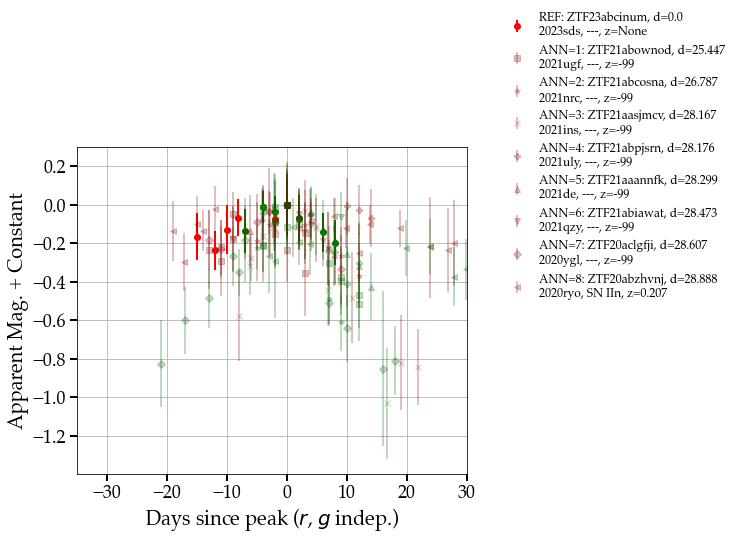

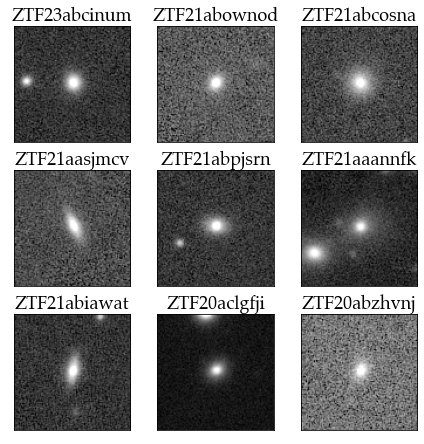


Running AD Model!...
Anomalous during timeseries!
max_anom_score 61.0
num_anom_epochs 3


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


MJD crossed thresh: 60211.382
https://alerce.online/object/ZTF23abcinum


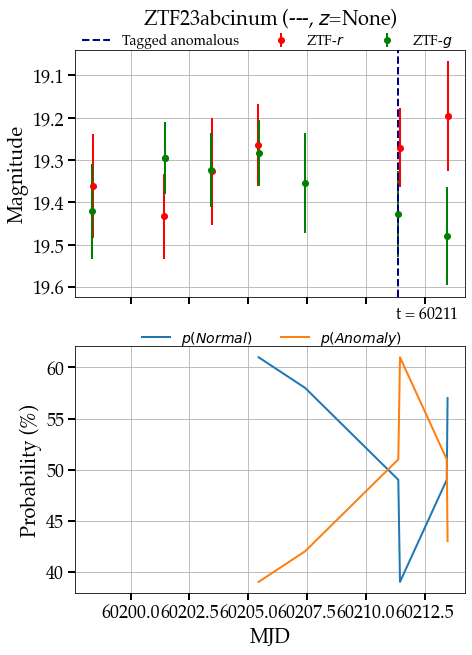

In [40]:
# paper ones  # ZTF21aaublej # ZTF20aciuftf #ZTF21aaaokyp
LAISS(l_or_ztfid_ref="ZTF23abcinum", # ZTF23abcvqkd #ZTF23aaxoybh #ZTF23aakawpn # ANT2023z0zr3w2y9pd6 
      scaler=scaler, 
      pca=pca, 
      idx_arr=idx_arr, 
      index=index, 
      lc_and_host_features=lc_and_host_features, 
      n=8,
      show_lightcurves_grid=True,
      show_hosts_grid=True,
      run_AD_model=True,
      savetables=False,
      savefigs=False)